In [40]:
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

## Load COPX Data

In [41]:
copx = yf.Ticker("COPX").history(period="max", interval="1d").reset_index()# yf.Ticker("COPX").history(period="1y", interval="1h")
copx = copx.drop(columns=['Dividends', 'Stock Splits', 'Capital Gains'])
copx = copx.sort_values(by='Date')
copx.head(3)

,Date,Open,High,Low,Close,Volume
0,2010-04-20 00:00:00-04:00,33.153586,33.153586,32.597318,32.664070,1933
1,2010-04-21 00:00:00-04:00,32.486067,32.708574,32.063303,32.152306,2900
2,2010-04-22 00:00:00-04:00,32.018804,32.018804,31.529288,31.974304,3600


## Feature Engineering

In [42]:
# High and Low as a percentage of Open
copx['High/Open(%)'] = copx['High']/ copx['Open']
copx['Low/Open(%)'] = copx['Low'] / copx['Open']

# Daily return based on Close
copx['Daily Return'] = copx['Close'].pct_change()  

# Date features
copx['Day of Week'] = copx['Date'].dt.day_name()
copx['Month'] = copx['Date'].dt.month
copx['Year'] = copx['Date'].dt.year

# Lag features
LAGS_DAY = [1, 2, 3, 4, 5, 10, 15, 20]
for LAG_DAY in LAGS_DAY:
    copx[f'High/Open(%) [{LAG_DAY} day]'] = copx['High/Open(%)'].shift(LAG_DAY)
    copx[f'Low/Open(%) [{LAG_DAY} day]'] = copx['Low/Open(%)'].shift(LAG_DAY)

# Moving Averages




copx = copx.dropna().reset_index()
copx

,index,Date,Open,High,Low,Close,Volume,High/Open(%),Low/Open(%),Daily Return,...,High/Open(%) [4 day],Low/Open(%) [4 day],High/Open(%) [5 day],Low/Open(%) [5 day],High/Open(%) [10 day],Low/Open(%) [10 day],High/Open(%) [15 day],Low/Open(%) [15 day],High/Open(%) [20 day],Low/Open(%) [20 day]
0,20,2010-05-18 00:00:00-04:00,26.678634,26.678634,25.388090,25.388090,3500,1.000000,0.951626,-0.024786,...,1.000000,0.987372,1.005569,0.994431,1.000000,0.944571,1.003484,0.969338,1.000000,0.983221
1,21,2010-05-19 00:00:00-04:00,24.698315,24.787317,23.941790,24.542561,767,1.003604,0.969369,-0.033304,...,1.004666,0.986781,1.000000,0.987372,1.040000,0.994167,1.000000,0.977983,1.006849,0.986986
2,22,2010-05-20 00:00:00-04:00,24.030793,24.030793,22.940506,23.229765,2333,1.000000,0.954630,-0.053491,...,1.000000,0.967872,1.004666,0.986781,1.003257,0.925081,1.000000,0.992176,1.000000,0.984712
3,23,2010-05-21 00:00:00-04:00,24.208798,24.698314,24.208798,24.631561,1400,1.020221,1.000000,0.060345,...,1.000000,0.920712,1.000000,0.967872,1.000000,0.959133,1.000000,0.960508,1.006983,0.995112
4,24,2010-05-24 00:00:00-04:00,24.898572,24.943074,24.542561,24.542561,1067,1.001787,0.985702,-0.003613,...,1.000000,0.951626,1.000000,0.920712,1.003946,0.994475,1.014870,0.989591,1.000000,0.962567
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3651,3671,2024-11-18 00:00:00-05:00,41.200001,42.209999,41.169998,42.180000,1194200,1.024515,0.999272,0.026277,...,1.002844,0.978436,1.002754,0.986003,1.014151,0.997978,1.006626,0.994037,1.000000,0.977884
3652,3672,2024-11-19 00:00:00-05:00,42.119999,42.959999,41.970001,42.900002,1055400,1.019943,0.996439,0.017070,...,1.005037,0.979611,1.002844,0.978436,1.013319,0.997336,1.000441,0.991178,1.001966,0.991263
3653,3673,2024-11-20 00:00:00-05:00,42.529999,42.930000,42.459999,42.529999,1196600,1.009405,0.998354,-0.008625,...,1.017630,0.997062,1.005037,0.979611,1.009195,0.979540,1.004270,0.991011,1.000886,0.984057
3654,3674,2024-11-21 00:00:00-05:00,42.529999,42.919998,42.320000,42.790001,812500,1.009170,0.995062,0.006113,...,1.005049,0.987016,1.017630,0.997062,1.026397,1.000000,1.003172,0.980512,1.002440,0.985803


## Baseline

In [50]:
principal = 100 # Starting dollars
take_profit_threshold = 1.05 # Can change
stop_loss_threshold = 0.80 # Can change

def get_profit_loss(row):
    take_profit = row['Open'] * take_profit_threshold
    stop_loss = row['Open'] * stop_loss_threshold
    if row['Low'] <= stop_loss:
        return stop_loss
    if row['High'] >= take_profit:
        return take_profit
    
    return row['Close']

copx['Value Sold Per Stock'] = copx.apply(get_profit_loss, axis=1)

copx['Total Value'] = None
for i in range(len(copx)):
    if i == 0:
        # The first row's Stock Value is the principal
        copx.loc[i, 'Total Value'] = principal
    else:
        # Calculate current row's Stock Value
        copx.loc[i, 'Total Value'] = (
            copx.loc[i - 1, 'Total Value'] / copx.loc[i, 'Open'] * copx.loc[i, 'Value Sold Per Stock']
        )
copx

,index,Date,Open,High,Low,Close,Volume,High/Open(%),Low/Open(%),Daily Return,...,High/Open(%) [5 day],Low/Open(%) [5 day],High/Open(%) [10 day],Low/Open(%) [10 day],High/Open(%) [15 day],Low/Open(%) [15 day],High/Open(%) [20 day],Low/Open(%) [20 day],Value Sold Per Stock,Total Value
0,20,2010-05-18 00:00:00-04:00,26.678634,26.678634,25.388090,25.388090,3500,1.000000,0.951626,-0.024786,...,1.005569,0.994431,1.000000,0.944571,1.003484,0.969338,1.000000,0.983221,25.388090,100
1,21,2010-05-19 00:00:00-04:00,24.698315,24.787317,23.941790,24.542561,767,1.003604,0.969369,-0.033304,...,1.000000,0.987372,1.040000,0.994167,1.000000,0.977983,1.006849,0.986986,24.542561,99.369372
2,22,2010-05-20 00:00:00-04:00,24.030793,24.030793,22.940506,23.229765,2333,1.000000,0.954630,-0.053491,...,1.004666,0.986781,1.003257,0.925081,1.000000,0.992176,1.000000,0.984712,23.229765,96.057054
3,23,2010-05-21 00:00:00-04:00,24.208798,24.698314,24.208798,24.631561,1400,1.020221,1.000000,0.060345,...,1.000000,0.967872,1.000000,0.959133,1.000000,0.960508,1.006983,0.995112,24.631561,97.73452
4,24,2010-05-24 00:00:00-04:00,24.898572,24.943074,24.542561,24.542561,1067,1.001787,0.985702,-0.003613,...,1.000000,0.920712,1.003946,0.994475,1.014870,0.989591,1.000000,0.962567,24.542561,96.337066
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3651,3671,2024-11-18 00:00:00-05:00,41.200001,42.209999,41.169998,42.180000,1194200,1.024515,0.999272,0.026277,...,1.002754,0.986003,1.014151,0.997978,1.006626,0.994037,1.000000,0.977884,42.180000,1.759966
3652,3672,2024-11-19 00:00:00-05:00,42.119999,42.959999,41.970001,42.900002,1055400,1.019943,0.996439,0.017070,...,1.002844,0.978436,1.013319,0.997336,1.000441,0.991178,1.001966,0.991263,42.900002,1.792558
3653,3673,2024-11-20 00:00:00-05:00,42.529999,42.930000,42.459999,42.529999,1196600,1.009405,0.998354,-0.008625,...,1.005037,0.979611,1.009195,0.979540,1.004270,0.991011,1.000886,0.984057,42.529999,1.792558
3654,3674,2024-11-21 00:00:00-05:00,42.529999,42.919998,42.320000,42.790001,812500,1.009170,0.995062,0.006113,...,1.017630,0.997062,1.026397,1.000000,1.003172,0.980512,1.002440,0.985803,42.790001,1.803516


## EDA

OptionError: "No such keys(s): 'mode.use_inf_as_null'"

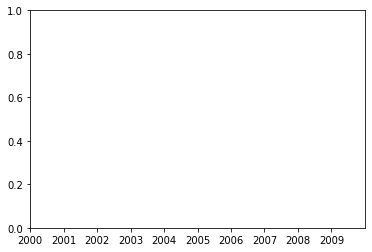

In [44]:
sns.lineplot(data=copx, x="Date", y="Close")
plt.show()

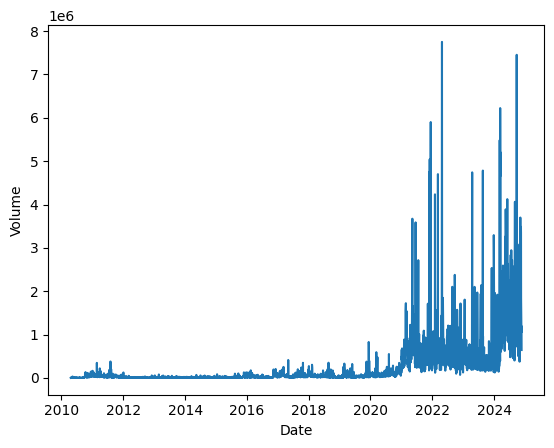

In [ ]:
sns.lineplot(data=copx, x="Date", y="Volume")
plt.show()